In [19]:
import gzip, json 
PAPER_JSON = '/data/jx4237data/Graph-CoT/Pipeline/2024_updated_data/papernodes_remove0/paper_nodes_GNN_yearly_9_year_citation_counts.json.gz'
print('[dataset_builder] loading paper JSON …')
with gzip.open(PAPER_JSON, 'rt', encoding='utf-8') as f:
    paper_json = json.load(f)

[dataset_builder] loading paper JSON …


In [25]:
for k ,v in paper_json.items():
    if v['features']['is_core'] == 1 and v['features']['AuthorNum'] > 5:
        print(k, v['features']['AuthorNum'])
        break

1281223 8


In [27]:
paper_json['1281223']

{'features': {'AuthorNum': 8,
  'PubYear': 1992,
  'CitedCount': 156,
  'Title': 'Validation of a new quality of life questionnaire for benign prostatic hyperplasia.',
  'Abstract': 'In planning a longitudinal study to characterize the natural history of benign prostatic hyperplasia (BPH), we validated a new disease-specific quality of life questionnaire in a pilot study. We studied 110 men in Rochester, Minnesota who spanned the severity of BPH, from men with no known BPH to men who underwent surgery for this condition. Baseline data were obtained on all men, and the 30 who underwent prostatectomy were re-interviewed to test responsiveness. Reproducibility was examined on the pre-post responses (10 weeks apart) of the 37 men with BPH who did not undergo prostatectomy. Six of twelve question domains were retained in the final questionnaire on the basis of their responsiveness to change, reproducibility, internal consistency, and validity. These were: urinary symptoms, degree of bother 

In [1]:
import torch
file_path ='/data/jx4237data/GNNteamingEvaluator/TeamingEvaluator/data/yearly_snapshots_specter2_starting_from_year_1/G_2018.pt'

G = torch.load(file_path)

print(G)

HeteroData(
  paper={
    x_title_emb=[5878, 768],
    y_citations=[5878, 5],
    is_core=[5878],
    y_year=[5878],
    raw_ids=[5878],
    x=[5878, 768]
  },
  author={
    x=[23597, 768],
    raw_ids=[23597]
  },
  venue={
    x=[1389, 768],
    raw_ids=[1389]
  },
  (author, writes, paper)={ edge_index=[2, 51156] },
  (paper, written_by, author)={ edge_index=[2, 51156] },
  (paper, cites, paper)={ edge_index=[2, 13271] },
  (paper, cited_by, paper)={ edge_index=[2, 13271] },
  (paper, published_in, venue)={ edge_index=[2, 5878] },
  (venue, publishes, paper)={ edge_index=[2, 5878] }
)


In [18]:
G['paper'].y_citations

tensor([[ 7,  7,  8, 13, 18],
        [ 0,  0,  0,  0,  0],
        [ 1,  0,  1,  0,  2],
        ...,
        [ 2,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 1,  5,  1,  1,  1]])

In [14]:
import torch
from collections import defaultdict

# Assuming G is your HeteroData object
def get_avg_references_2018(G):
    # Get papers published in 2018
    papers_2018_mask = (G['paper'].y_year == 2010)
    papers_2018_indices = torch.where(papers_2018_mask)[0]
    
    print(f"Number of papers published in 2018: {len(papers_2018_indices)}")
    
    if len(papers_2018_indices) == 0:
        print("No papers found for 2018")
        return 0
    
    # Get citation edges (paper -> paper that it cites)
    cite_edges = G[('paper', 'cites', 'paper')].edge_index
    
    # Count outgoing citations (references) for each paper
    ref_counts = defaultdict(int)
    
    # cite_edges[0] contains source papers, cite_edges[1] contains target papers
    for i in range(cite_edges.shape[1]):
        source_paper = cite_edges[0, i].item()
        ref_counts[source_paper] += 1
    
    # Calculate total references for 2018 papers
    total_refs_2018 = 0
    papers_with_refs = 0
    
    for paper_idx in papers_2018_indices:
        paper_idx = paper_idx.item()
        refs = ref_counts[paper_idx]
        total_refs_2018 += refs
        if refs > 0:
            papers_with_refs += 1
    
    # Calculate averages
    avg_refs_all = total_refs_2018 / len(papers_2018_indices)
    avg_refs_with_refs = total_refs_2018 / papers_with_refs if papers_with_refs > 0 else 0
    
    print(f"Total references made by 2018 papers: {total_refs_2018}")
    print(f"Papers with at least one reference: {papers_with_refs}")
    print(f"Average references per 2018 paper (including papers with 0 refs): {avg_refs_all:.2f}")
    print(f"Average references per 2018 paper (only papers with refs): {avg_refs_with_refs:.2f}")
    
    return avg_refs_all

# Usage
avg_references = get_avg_references_2018(G)
print(f"\nFinal answer: {avg_references:.2f} references per paper in 2018")

Number of papers published in 2018: 285
Total references made by 2018 papers: 661
Papers with at least one reference: 202
Average references per 2018 paper (including papers with 0 refs): 2.32
Average references per 2018 paper (only papers with refs): 3.27

Final answer: 2.32 references per paper in 2018


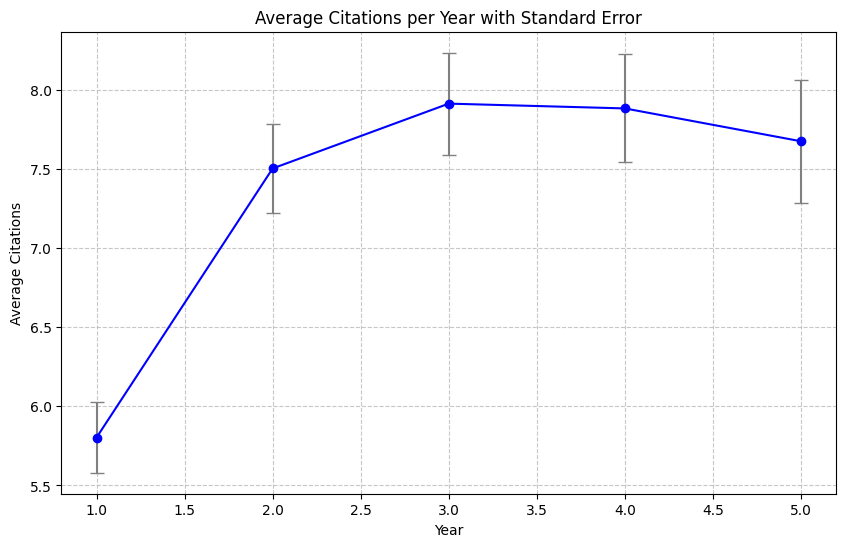

In [28]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load the data
file_path = '/data/jx4237data/GNNteamingEvaluator/TeamingEvaluator/data/yearly_snapshots_specter2_starting_from_year_1/G_2018.pt'
G = torch.load(file_path)

# Get citation data
citations = G['paper']['y_citations'].numpy()

# Calculate mean and standard error for each year
mean_citations = np.mean(citations, axis=0)
std_citations = np.std(citations, axis=0)
std_error = std_citations / np.sqrt(len(citations))

# Create the plot
years = np.arange(1, 6)  # Years 1-5
plt.figure(figsize=(10, 6))
plt.errorbar(years, mean_citations, yerr=std_error, fmt='o-', capsize=5, capthick=1, ecolor='gray', color='blue')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Average Citations')
plt.title('Average Citations per Year with Standard Error')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()